In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class ACGANGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_channels):
        super(ACGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_channels = img_channels
        
        # Input: latent_dim + num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.BatchNorm1d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(1024, img_channels * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate noise and labels
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), self.img_channels, 64, 64)
        return img


In [4]:
class ACGANDiscriminator(nn.Module):
    def __init__(self, img_channels, num_classes):
        super(ACGANDiscriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(img_channels * 64 * 64, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128, num_classes), nn.Softmax(dim=1))

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        features = self.model(img_flat)
        
        # Discriminator output: real/fake
        validity = self.adv_layer(features)
        
        # Auxiliary output: class labels
        label = self.aux_layer(features)

        return validity, label


In [5]:
# Hyperparameters
latent_dim = 100
num_classes = 6
img_channels = 3
learning_rate = 0.0002
batch_size = 76

# Initialize generator and discriminator
generator = ACGANGenerator(latent_dim, num_classes, img_channels)
discriminator = ACGANDiscriminator(img_channels, num_classes)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss functions
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()


In [6]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize images to [-1, 1]
])

# Load dataset using ImageFolder
base_dir = 'DIAT-uSAT_dataset'  # Make sure this path is correct
dataset = ImageFolder(base_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)


In [7]:
num_epochs = 20
best_g_loss = float('inf')  # Initialize best generator loss as infinity

for epoch in range(num_epochs):
    total_g_loss = 0.0
    total_d_loss = 0.0
    num_batches = len(dataloader)
    
    for i, (imgs, labels) in enumerate(dataloader):
        
        batch_size = imgs.size(0)
        valid = torch.ones((batch_size, 1), requires_grad=False)
        fake = torch.zeros((batch_size, 1), requires_grad=False)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim)
        gen_labels = torch.randint(0, num_classes, (batch_size,))

        gen_imgs = generator(z, gen_labels)
        validity, pred_label = discriminator(gen_imgs)

        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        real_pred, real_aux = discriminator(imgs)
        d_real_loss = (0.5 * (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)))

        # Fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (0.5 * (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)))

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Accumulate losses
        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    # Calculate average losses for the epoch
    avg_g_loss = total_g_loss / num_batches
    avg_d_loss = total_d_loss / num_batches

    # Print the average losses per epoch
    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}]")

    # Save the generator if the current epoch's generator loss is the lowest
    if avg_g_loss < best_g_loss:
        best_g_loss = avg_g_loss
        torch.save(generator.state_dict(), "best_generator_model.pt")  # Save to the same file

[Epoch 1/20] [D loss: 0.9779] [G loss: 1.1988]
[Epoch 2/20] [D loss: 0.9347] [G loss: 1.0914]
[Epoch 3/20] [D loss: 0.9119] [G loss: 1.0136]
[Epoch 4/20] [D loss: 0.9104] [G loss: 0.9937]
[Epoch 5/20] [D loss: 0.9026] [G loss: 0.9972]
[Epoch 6/20] [D loss: 0.8995] [G loss: 0.9946]
[Epoch 7/20] [D loss: 0.8974] [G loss: 0.9951]
[Epoch 8/20] [D loss: 0.9061] [G loss: 0.9786]
[Epoch 9/20] [D loss: 0.9017] [G loss: 0.9682]
[Epoch 10/20] [D loss: 0.9032] [G loss: 0.9746]
[Epoch 11/20] [D loss: 0.8967] [G loss: 0.9706]
[Epoch 12/20] [D loss: 0.8922] [G loss: 0.9781]
[Epoch 13/20] [D loss: 0.8892] [G loss: 0.9826]
[Epoch 14/20] [D loss: 0.8847] [G loss: 0.9848]
[Epoch 15/20] [D loss: 0.8862] [G loss: 0.9825]
[Epoch 16/20] [D loss: 0.8916] [G loss: 0.9760]
[Epoch 17/20] [D loss: 0.8896] [G loss: 0.9843]
[Epoch 18/20] [D loss: 0.8882] [G loss: 0.9701]
[Epoch 19/20] [D loss: 0.8879] [G loss: 0.9716]
[Epoch 20/20] [D loss: 0.8952] [G loss: 0.9641]


Generator is on device: cuda:0
Noise is on device: cuda:0
Labels are on device: cuda:0
Generated images shape: torch.Size([6, 3, 64, 64])
Grid shape: torch.Size([3, 68, 398])


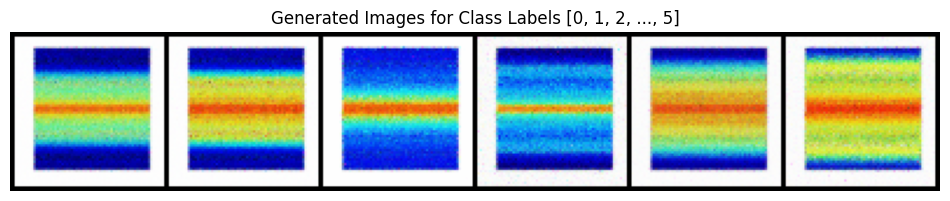

In [8]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def test_generator(generator, num_classes, latent_dim, device):
    # Set the generator to evaluation mode
    generator.eval()
    
    # Generate random noise and class labels
    z = torch.randn(num_classes, latent_dim).to(device)  # Generate noise
    labels = torch.arange(num_classes).to(device)  # Class labels [0, 1, 2, ..., num_classes-1]
    
    # Move the generator to the specified device (if it's not already there)
    generator = generator.to(device)
    
    # Debugging: Check the device
    print(f"Generator is on device: {next(generator.parameters()).device}")
    print(f"Noise is on device: {z.device}")
    print(f"Labels are on device: {labels.device}")
    
    # Generate images
    with torch.no_grad():  # No need to compute gradients during testing
        gen_imgs = generator(z, labels)
    
    # Debugging: Print shape of generated images
    print(f"Generated images shape: {gen_imgs.shape}")
    
    # Unnormalize the images from [-1, 1] back to [0, 1] for visualization
    gen_imgs = (gen_imgs + 1) / 2.0
    
    # Create a grid of images and display them
    grid = make_grid(gen_imgs.cpu(), nrow=num_classes, normalize=False)
    
    # Debugging: Check grid shape
    print(f"Grid shape: {grid.shape}")
    
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Generated Images for Class Labels [0, 1, 2, ..., {num_classes-1}]")
    plt.axis("off")
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_generator(generator, num_classes=6, latent_dim=100, device=device)

In [9]:
import torch

def test_discriminator(discriminator, generator, dataloader, num_classes, latent_dim, device):
    # Set the models to evaluation mode
    discriminator = discriminator.to(device)  # Move discriminator to the correct device
    generator = generator.to(device)  # Move generator to the correct device
    
    discriminator.eval()
    generator.eval()

    # Initialize lists to store accuracy for real and fake images
    real_accuracy = 0
    fake_accuracy = 0
    class_accuracy = 0
    total_samples = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            batch_size = imgs.size(0)
            total_samples += batch_size

            imgs = imgs.to(device)
            labels = labels.to(device)
            real_pred, real_aux = discriminator(imgs)
            real_accuracy += (real_pred > 0.5).float().mean().item()  # Binary classification for real/fake
            class_accuracy += (real_aux.argmax(dim=1) == labels).float().mean().item()  # Class accuracy

            # Fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            gen_imgs = generator(z, gen_labels)

            fake_pred, fake_aux = discriminator(gen_imgs)
            fake_accuracy += (fake_pred < 0.5).float().mean().item()  # Fake should be classified as 0 (fake)
            class_accuracy += (fake_aux.argmax(dim=1) == gen_labels).float().mean().item()

    # Calculate average accuracies
    real_accuracy /= len(dataloader)
    fake_accuracy /= len(dataloader)
    class_accuracy /= (2 * len(dataloader))  # Since class accuracy is measured for both real and fake

    print(f"Discriminator Real Accuracy: {real_accuracy * 100:.2f}%")
    print(f"Discriminator Fake Accuracy: {fake_accuracy * 100:.2f}%")
    print(f"Discriminator Class Accuracy: {class_accuracy * 100:.2f}%")

# Example usage 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_discriminator(discriminator, generator, dataloader, num_classes=6, latent_dim=100, device=device)



Discriminator Real Accuracy: 77.32%
Discriminator Fake Accuracy: 64.58%
Discriminator Class Accuracy: 90.37%


In [12]:
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image

In [14]:
# Define the custom dataset to load and preprocess images
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, subfolders, transform=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            label = subfolder

            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Define the base directory and subfolders
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    r"3_long_blade_rotor", 
    r"3_short_blade_rotor", 
    r"Bird", 
    r"Bird+mini-helicopter", 
    r"drone", 
    r"rc_plane", 
]

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

In [15]:
dataset = CustomImageDataset(base_dir, subfolders, transform=transform)

In [16]:
torch.manual_seed(42) 
indices = torch.randperm(len(dataset)) 
shuffled_dataset = torch.utils.data.Subset(dataset, indices)

In [17]:
train_size = int(0.85 * len(shuffled_dataset))
val_size = int(0.05 * len(shuffled_dataset))
test_size = len(shuffled_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(shuffled_dataset, [train_size, val_size, test_size])

In [18]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        # Reduce channels to 1 using convolution
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)
        # Another convolution layer to learn weights across spatial dimensions
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Apply first convolution to reduce channels to 1
        attn = self.conv1(x)
        # Apply second convolution to learn spatial importance
        attn = self.conv2(attn)
        # Apply sigmoid to normalize between 0 and 1
        attn = torch.sigmoid(attn)
        # Multiply the attention map with the original feature map
        return x * attn

# Custom VGG16 with attention
class CustomVGGWithAttention(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomVGGWithAttention, self).__init__()
        self.features = base_model.features  # Use pretrained VGG16 feature extractor
        self.avgpool = base_model.avgpool  # VGG16 average pooling layer
        self.attention = SpatialAttention(in_channels=512)  # Spatial attention module
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),  # Adjust input size based on feature map size after pooling
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # Final output layer
        )

    def forward(self, x):
        # Pass through VGG16 feature extractor
        x = self.features(x)
        # Apply attention mechanism
        x = self.attention(x)
        # Pass through average pooling layer
        x = self.avgpool(x)
        # Flatten the output
        x = torch.flatten(x, 1)
        # Pass through the classifier
        x = self.classifier(x)
        return x



In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    model.train()
    best_acc = 0.0
    best_model_saved = False  # Flag to ensure the best model is saved only once

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0

        # Training loop
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Save the best model only once
        if val_acc > best_acc and not best_model_saved:
            best_acc = val_acc
            best_model_saved = True  # Set flag to true after saving
            torch.save(model.state_dict(), f"best_model_{model.__class__.__name__}.pt")

        model.train()  # Set back to training mode

# Example usage
# Load pretrained VGG16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_base = models.vgg16(pretrained=True)
for param in vgg16_base.parameters():
    param.requires_grad = False  # Freeze VGG16 layers

# Create attention-based model
model_with_attention = CustomVGGWithAttention(vgg16_base, num_classes=6)
model_with_attention = model_with_attention.to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_attention.classifier.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)

# Train the model
train_model(model_with_attention, train_loader, val_loader, criterion, optimizer, scheduler)


c:\Users\Shravya H Jain\Desktop\ML+AI\Micro-Doppler-Based-Target-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Shravya H Jain\Desktop\ML+AI\Micro-Doppler-Based-Target-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Shravya H Jain\Desktop\ML+AI\Micro-Doppler-Based-Target-Classification\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

Epoch [1/15], Loss: 0.5541, Accuracy: 0.8204
Validation Loss: 0.2554, Validation Accuracy: 0.9174
Epoch [2/15], Loss: 0.2410, Accuracy: 0.9243
Validation Loss: 0.1436, Validation Accuracy: 0.9711
Epoch [3/15], Loss: 0.1652, Accuracy: 0.9486
Validation Loss: 0.1079, Validation Accuracy: 0.9587
Epoch [4/15], Loss: 0.1261, Accuracy: 0.9604
Validation Loss: 0.1015, Validation Accuracy: 0.9835
Epoch [5/15], Loss: 0.1060, Accuracy: 0.9706
Validation Loss: 0.0886, Validation Accuracy: 0.9711
Epoch [6/15], Loss: 0.0888, Accuracy: 0.9731
Validation Loss: 0.0655, Validation Accuracy: 0.9793
Epoch [7/15], Loss: 0.0720, Accuracy: 0.9779
Validation Loss: 0.0350, Validation Accuracy: 0.9959
Epoch [8/15], Loss: 0.0576, Accuracy: 0.9823
Validation Loss: 0.0411, Validation Accuracy: 0.9876
Epoch [9/15], Loss: 0.0589, Accuracy: 0.9825
Validation Loss: 0.0353, Validation Accuracy: 0.9917
Epoch [10/15], Loss: 0.0496, Accuracy: 0.9859
Validation Loss: 0.0429, Validation Accuracy: 0.9917
Epoch [11/15], Loss

In [24]:
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_corrects = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient calculations
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * images.size(0)
            test_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
    
    test_loss /= total_samples
    test_acc = test_corrects.double() / total_samples
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Example of loading the test data






In [25]:
test_model(model_with_attention, test_loader, criterion)

Test Loss: 0.0378, Test Accuracy: 0.9856
